# Act 7. Regresion Logistica
_____________________________

- Angel Ruben Vazquez Rivera |
- Jose Israel Perez Ontiveros | A01423294  
- Maximiliano Romero Budib |

### 1. Importar librerias

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.special as special
from scipy.optimize import curve_fit
import seaborn as sns
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, precision_score, accuracy_score, recall_score, f1_score

### 2. Cargar archivo

In [2]:
data = pd.read_csv('./Recursos/TrainingDataComplete.csv', index_col=0)
display(data)

,Income,Age,Experience,Married/Single,House_Ownership,Car_Ownership,Profession,CITY,STATE,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS,Risk_Flag
Id,,,,,,,,,,,,
1,1303834,23,3,single,rented,no,Mechanical_engineer,Rewa,Madhya_Pradesh,3,13,0
2,7574516,40,10,single,rented,no,Software_Developer,Parbhani,Maharashtra,9,13,0
3,3991815,66,4,married,rented,no,Technical_writer,Alappuzha,Kerala,4,10,0
4,6256451,41,2,single,rented,yes,Software_Developer,Bhubaneswar,Odisha,2,12,1
5,5768871,47,11,single,rented,no,Civil_servant,Tiruchirappalli[10],Tamil_Nadu,3,14,1
...,...,...,...,...,...,...,...,...,...,...,...,...
251996,8154883,43,13,single,rented,no,Surgeon,Kolkata,West_Bengal,6,11,0
251997,2843572,26,10,single,rented,no,Army_officer,Rewa,Madhya_Pradesh,6,11,0
251998,4522448,46,7,single,rented,no,Design_Engineer,Kalyan-Dombivli,Maharashtra,7,12,0


### 3. Preprocesamiento

In [3]:
# Verificamos info del DF
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 252000 entries, 1 to 252000
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Income             252000 non-null  int64 
 1   Age                252000 non-null  int64 
 2   Experience         252000 non-null  int64 
 3   Married/Single     252000 non-null  object
 4   House_Ownership    252000 non-null  object
 5   Car_Ownership      252000 non-null  object
 6   Profession         252000 non-null  object
 7   CITY               252000 non-null  object
 8   STATE              252000 non-null  object
 9   CURRENT_JOB_YRS    252000 non-null  int64 
 10  CURRENT_HOUSE_YRS  252000 non-null  int64 
 11  Risk_Flag          252000 non-null  int64 
dtypes: int64(6), object(6)
memory usage: 25.0+ MB


In [4]:
# Separamos columnas cualitativas de cuantitativas
data['Risk_Flag'] = data['Risk_Flag'].replace({0: 'No', 1: 'Yes'})

dataCuantitativas = data.select_dtypes(include=['int64'])
dataCualitativas = data.select_dtypes(include=['object'])


print(f'Columnas cuantitativas:\n{dataCuantitativas.columns}')
print(f'\nColumnas cualitativas:\n{dataCualitativas.columns}')



Columnas cuantitativas:
Index(['Income', 'Age', 'Experience', 'CURRENT_JOB_YRS', 'CURRENT_HOUSE_YRS'], dtype='object')

Columnas cualitativas:
Index(['Married/Single', 'House_Ownership', 'Car_Ownership', 'Profession',
       'CITY', 'STATE', 'Risk_Flag'],
      dtype='object')


In [5]:
# Verificamos valores nulos
valores_nulos = data.isnull().sum()
print(valores_nulos)

Income               0
Age                  0
Experience           0
Married/Single       0
House_Ownership      0
Car_Ownership        0
Profession           0
CITY                 0
STATE                0
CURRENT_JOB_YRS      0
CURRENT_HOUSE_YRS    0
Risk_Flag            0
dtype: int64


<Figure size 1500x800 with 0 Axes>

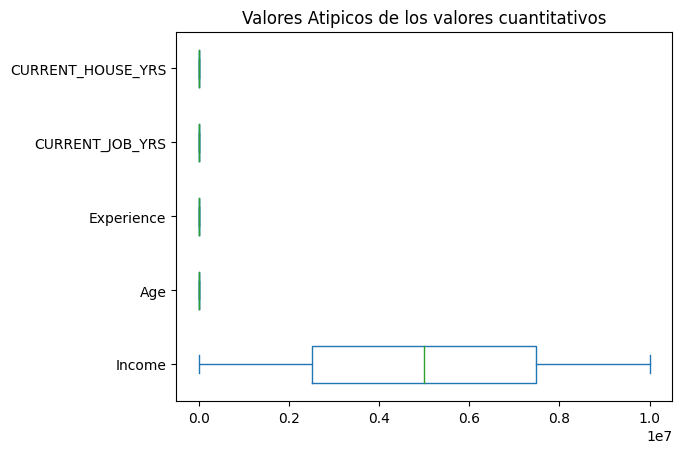

In [6]:
# Distribucion de valores atipicos
fig = plt.figure(figsize = (15, 8))
dataCuantitativas.plot(kind='box', vert=False)
plt.title('Valores Atipicos de los valores cuantitativos')
plt.show()

In [7]:
# Metodo cuantiles
# Encontramos los valores extremos
y = dataCuantitativas

percentile25 = y.quantile(0.25) #Q1
percentile75 = y.quantile(0.75) #Q3

iqr = percentile75 - percentile25

limiteSuperiorIQR = percentile75 + 1.5 * iqr
limiteInferiorIQR = percentile25 - 1.5 * iqr


print(f"Limite superior permitido :")
for col, val in limiteSuperiorIQR.items():
    print(f"{col}: {round(val, 2)}")

print(f"\n\nLimite inferior permitido :")
for col, val in limiteInferiorIQR.items():
    print(f"{col}: {round(val, 2)}")

Limite superior permitido :
Income: 14939232.5
Age: 110.0
Experience: 30.0
CURRENT_JOB_YRS: 18.0
CURRENT_HOUSE_YRS: 16.0


Limite inferior permitido :
Income: -4958715.5
Age: -10.0
Experience: -10.0
CURRENT_JOB_YRS: -6.0
CURRENT_HOUSE_YRS: 8.0


In [8]:
# Encontramos Outliers
outliers = dataCuantitativas[(y>limiteSuperiorIQR) | (y<limiteInferiorIQR)]
print(f"\nOutliers:\n")
for col, val in outliers.items():
    print(f"{col}: {round(val, 2)}")


Outliers:

Income: Id
1        NaN
2        NaN
3        NaN
4        NaN
5        NaN
          ..
251996   NaN
251997   NaN
251998   NaN
251999   NaN
252000   NaN
Name: Income, Length: 252000, dtype: float64
Age: Id
1        NaN
2        NaN
3        NaN
4        NaN
5        NaN
          ..
251996   NaN
251997   NaN
251998   NaN
251999   NaN
252000   NaN
Name: Age, Length: 252000, dtype: float64
Experience: Id
1        NaN
2        NaN
3        NaN
4        NaN
5        NaN
          ..
251996   NaN
251997   NaN
251998   NaN
251999   NaN
252000   NaN
Name: Experience, Length: 252000, dtype: float64
CURRENT_JOB_YRS: Id
1        NaN
2        NaN
3        NaN
4        NaN
5        NaN
          ..
251996   NaN
251997   NaN
251998   NaN
251999   NaN
252000   NaN
Name: CURRENT_JOB_YRS, Length: 252000, dtype: float64
CURRENT_HOUSE_YRS: Id
1        NaN
2        NaN
3        NaN
4        NaN
5        NaN
          ..
251996   NaN
251997   NaN
251998   NaN
251999   NaN
252000   NaN
Name: C

In [9]:
# Convertir outliers en nulos
dataCuantitativas = dataCuantitativas[(y<=limiteSuperiorIQR) & (y>=limiteInferiorIQR)]
display(dataCuantitativas)

,Income,Age,Experience,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS
Id,,,,,
1,1303834,23,3,3,13
2,7574516,40,10,9,13
3,3991815,66,4,4,10
4,6256451,41,2,2,12
5,5768871,47,11,3,14
...,...,...,...,...,...
251996,8154883,43,13,6,11
251997,2843572,26,10,6,11
251998,4522448,46,7,7,12


In [10]:
# Corroboramos valores nulos
valores_nulos = dataCuantitativas.isnull().sum()
print(valores_nulos)

Income               0
Age                  0
Experience           0
CURRENT_JOB_YRS      0
CURRENT_HOUSE_YRS    0
dtype: int64


### 4. Analisis de correlacion